In [44]:
#import nctoolkit as nc
import os
#import urllib
from netCDF4 import Dataset
print('imported')
import numpy as npy
import matplotlib.pylab as plt

figdir = '/Users/heareg/Documents/Floes/working_directory/figures/'

use_OSISAF = 0
use_Bremen = 1

if use_OSISAF:
    figdir = figdir + 'OSI'
elif use_Bremen:
    figdir = figdir + 'Bremen'

#savename = "OSISAF_ice_type_agg_SH.nc"
#
#if os.path.isfile(savename):
#    this_dataset = Dataset(savename)
#else:
#    thredds_add = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/type403d_sh_agg?Polar_Stereographic_Grid,xc[0:1:789],yc[0:1:829],lat[0:1:0][0:1:0],lon[0:1:0][0:1:0],time[0:1:532],time_bnds[0:1:532][0:1:1],ice_type[0:1:0][0:1:0][0:1:0],status_flag[0:1:0][0:1:0][0:1:0],uncertainty[0:1:0][0:1:0][0:1:0],param_used[0:1:0][0:1:0][0:1:0],orbit_num_ascat[0:1:0][0:1:0][0:1:0],orbit_num_amsr[0:1:0][0:1:0][0:1:0],orbit_num_ssmis[0:1:0][0:1:0][0:1:0]'
#    f = urllib.request.urlopen(thredds_add)
#    myfile = f.read()
#    print(myfile)
#    
#    #ds = nc.open_thredds(thredds_add)
#    #ds.keys()


imported


In [45]:
import sys
#!conda install --yes --prefix {sys.prefix} cv2
!{sys.executable} -m pip install ffmpeg
import ffmpeg

here


(300.0, 570.0)

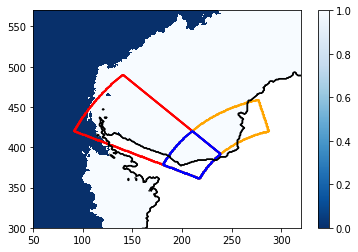

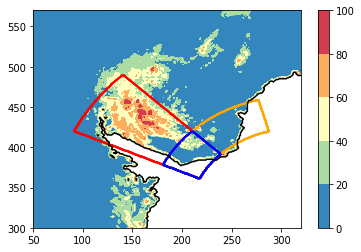

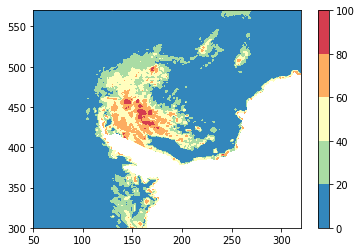

In [46]:


if use_OSISAF:
    datadir = '/Users/heareg/Documents/OSISAF_SH/'
    fname_conc_st = 'ice_conc_sh_polstere-100_multi_'
    this_f = Dataset(datadir+'2022/07/'+fname_conc_st+'202207221200.nc')
    this_f.variables
    lat = npy.squeeze(npy.array(this_f.variables['lat']))
    lon = npy.squeeze(npy.array(this_f.variables['lon']))
    ice_conc = npy.squeeze(npy.array(this_f.variables['ice_conc']))
    status_flag = npy.squeeze(npy.array(this_f.variables['status_flag']))

    
    datadir = '/Users/heareg/Documents/OSISAF_SH/'
    #fname_conc_st = 'ice_conc_sh_polstere-100_multi_'
    fname_type_st = 'ice_type_sh_polstere-100_multi_'

    this_t = Dataset(datadir+'2022_type/07/'+fname_type_st+'202207221200.nc')
    ice_type = npy.squeeze(npy.array(this_t.variables['ice_type']))
    ### 1 = no/little ice, 2 = young ice, 3 = myi, 4 = ambiguous 
    
    WWSbox = npy.zeros(npy.shape(lon))
    WWSbox[(lon>-65)&(lon<-45)&(lat>-77.6)&(lat<-62)] = 1
    SWSbox = npy.zeros(npy.shape(lon))
    SWSbox[(lon>-65)&(lon<-15)&(lat>-77.6)&(lat<-73)] = 1
    Bothbox = npy.zeros(npy.shape(lon))
    Bothbox[WWSbox+SWSbox==2] = 1

    landmask = npy.ones(npy.shape(ice_conc))
    landmask[status_flag>=100] = npy.nan
    ice_conc[status_flag>=100] = npy.nan
    
    cell_area = 12500 ## ish

elif use_Bremen:
    #datadir = '/Users/heareg/Documents/IceType_SH_Bremen/'
    #fname_type_st = 'MultiYearIce-Antarctic-'
    #this_t = Dataset(datadir+'2022/'+fname_type_st+'20220722.nc')
    datadir = '/Users/heareg/Documents/IceType_SH_Bremen/'
    typedir = datadir+'RAW/'
    fname_type_st = 'ECICE-IcetypesUncorrected-'
    this_t = Dataset(typedir+'2022/'+fname_type_st+'20220722.nc')    
    OW = npy.squeeze(npy.array(this_t.variables['OW']))
    YI = npy.squeeze(npy.array(this_t.variables['YI']))
    FYI = npy.squeeze(npy.array(this_t.variables['FYI']))
    MYI = npy.squeeze(npy.array(this_t.variables['MYI']))
    lon = npy.squeeze(npy.array(this_t.variables['LON']))
    lat = npy.squeeze(npy.array(this_t.variables['LAT']))
    
    ice_conc = YI + FYI + MYI;
    
    WWSbox = npy.zeros(npy.shape(lon))
    WWSbox[(lon>-65)&(lon<-45)&(lat>-77.6)&(lat<-62)] = 1
    SWSbox = npy.zeros(npy.shape(lon))
    SWSbox[(lon>-65)&(lon<-15)&(lat>-77.6)&(lat<-73)] = 1
    Bothbox = npy.zeros(npy.shape(lon))
    Bothbox[WWSbox+SWSbox==2] = 1

    landmask = npy.ones(npy.shape(ice_conc))
    landmask_10 = npy.zeros(npy.shape(ice_conc))
    landmask[npy.isnan(ice_conc)] = npy.nan
    landmask_10[npy.isnan(ice_conc)] = 1
    ice_conc[npy.isnan(ice_conc)] = npy.nan
    
    cell_area = npy.squeeze(npy.array(Dataset(datadir+'GridCellArea/PolStereo_GridCellArea_s12.5km_Antarctic.nc').variables['data']))
    print('here')
    
#ice_type[ice_type==-1] = npy.nan

plt.figure()
plt.pcolormesh(npy.flipud(ice_conc*landmask),vmin=0,vmax=1,cmap='Blues_r'); plt.colorbar()
plt.contour(npy.flipud(WWSbox),colors='r')
plt.contour(npy.flipud(SWSbox),colors='orange')
plt.contour(npy.flipud(Bothbox),colors='blue')
#plt.contour(npy.flipud(status_flag),[100,101],colors='k')
plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
if use_OSISAF:
    plt.contour(npy.flipud(status_flag),[100,101],colors='k')
    plt.xlim([100,400])
    plt.ylim([400,700])
else:
    plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
    plt.xlim([50,320])
    plt.ylim([300,570])
    
plt.figure()
plt.contourf(npy.flipud(MYI*landmask),4,cmap='Spectral_r'); plt.colorbar()
plt.contour(npy.flipud(WWSbox),colors='r')
plt.contour(npy.flipud(SWSbox),colors='orange')
plt.contour(npy.flipud(Bothbox),colors='blue')
if use_OSISAF:
    plt.contour(npy.flipud(status_flag),[100,101],colors='k')
    plt.xlim([100,400])
    plt.ylim([400,700])
else:
    plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
    plt.xlim([50,320])
    plt.ylim([300,570])

plt.figure()
plt.contourf(npy.flipud(MYI),4,cmap='Spectral_r'); plt.colorbar()
#plt.contour(npy.flipud(WWSbox),colors='r')
#plt.contour(npy.flipud(SWSbox),colors='orange')
#plt.contour(npy.flipud(Bothbox),colors='blue')
#plt.contour(npy.flipud(status_flag),[100,101],colors='k')
plt.xlim([50,320])
plt.ylim([300,570])
#print(lat[0:10,0:10])

(664, 632)
(664, 632)
(664, 632)


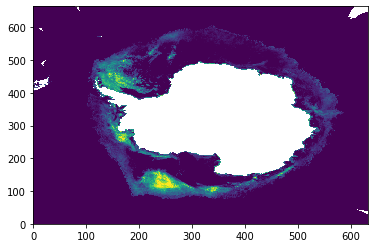

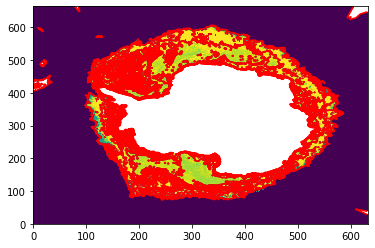

In [47]:

x0 = 0
y0 = 0
x1 = 790
y1 = 830

#x0 = 79
#x1 = 711

#y0 = 83
#y1 = 747

print(npy.shape(npy.flipud(ice_conc)))
MYIland = npy.flipud(this_t.variables['MYI'])*1
MYIland[npy.isnan(MYIland)] = 10
plt.figure()
plt.pcolormesh(npy.flipud(this_t.variables['MYI']))
plt.figure()
plt.pcolormesh(npy.flipud(ice_conc)[y0:y1,x0:x1])
plt.contour(npy.flipud(this_t.variables['MYI']))
plt.contour(MYIland,colors='r')
print(npy.shape(MYIland))
print(npy.shape(npy.flipud(ice_conc)[y0:y1,x0:x1]))

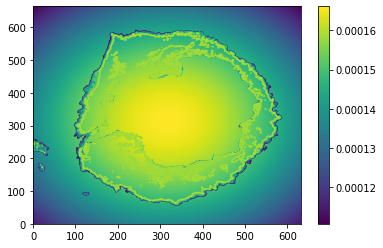

In [48]:
import numpy as np
from math import *



def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def area(lon_in,lat_in):

  ## At the moment it assumes lat and lon are 1d. If 2d, need to do something about populating dx and dy
  if npy.ndim(lon_in) == 1:
    lon = lon_in.copy()
    ## If it's 1d
    londim = lon.size
    lon_start = lon[0]-(lon[1]-lon[0])/2
    lon_end = lon[-1]+(lon[-1]-lon[-2])/2
    lon_av = npy.array((lon[-(londim-1):]+lon[0:londim-1])/2)#lon_av = npy.array((lon[1:-1]+lon[0:-2])/2)
    lon_loop = npy.concatenate(([lon_start],lon_av,[lon_end]))
  else:
    #Do this bit
    londim = lon_in.shape[1]
    lon_loop = lon_in*1

  if npy.ndim(lat_in) == 1:
    lat = lat_in.copy()
    latdim = lat.size
    lat_start = lat[0]-(lat[1]-lat[0])/2
    lat_end = lat[-1]+(lat[-1]-lat[-2])/2
    lat_av = (lat[-(latdim-1):]+lat[0:latdim-1])/2
    lat_loop = npy.concatenate(([lat_start],lat_av,[lat_end]))
  else:
    #Do this bit
    latdim = lat_in.shape[0]
    lat_loop = lat_in*1

  dx = -999*npy.ones([latdim,londim])
  dy = -999*npy.ones([latdim,londim])

  #Loop over longitudes to populate latitude distances
  for loncnt in range(0,londim):
    for lat_inc in range(0,latdim):
      if npy.ndim(lon_in) == 1:
        dy[lat_inc,loncnt] = npy.abs(dist(lon_in[loncnt],lat_loop[lat_inc],lon_in[loncnt],lat_loop[lat_inc+1]))
      else:
        if lat_inc < latdim-1:
          dy[lat_inc,loncnt] = npy.abs(dist(lon_in[lat_inc,loncnt],lat_in[lat_inc,loncnt],lon_in[lat_inc,loncnt],lat_in[lat_inc+1,loncnt]))
#      dy[lat_inc,loncnt] = CalculateArea.dist(float(lon[loncnt]),float(lat_loop[lat_inc]),float(lon[loncnt]),float(lat_loop[lat_inc+1]))


  for latcnt in range(0,latdim):
    for lon_inc in range(0,londim):
      if npy.ndim(lat_in) == 1:
        dx[latcnt,lon_inc] = npy.abs(dist(lon_loop[lon_inc],lat_in[latcnt],lon_loop[lon_inc+1],lat_in[latcnt]))
      else:
        if lat_inc < londim-1:
          dx[latcnt,lon_inc] = npy.abs(dist(lon_in[latcnt,lon_inc],lat_in[latcnt,lon_inc],lon_in[latcnt,lon_inc+1],lat_in[latcnt,lon_inc]))
#      dx[latcnt,lon_inc] = CalculateArea.dist(lon_loop[lon_inc],lat[latcnt],lon_loop[lon_inc+1],lat[latcnt])

  return dx, dy

if use_OSISAF:
    dx,dy = area(lon,lat)
    grid_area = dx*dy
else:
    grid_area = cell_area

plt.figure()
plt.pcolormesh(grid_area/1e6); plt.colorbar()
plt.contour(ice_conc)



In [49]:
def get_conc_and_type_OSISAF(year,month,day):
        datadir = '/Users/heareg/Documents/OSISAF_SH/'
        fname_conc_st = 'ice_conc_sh_polstere-100_multi_'
        fname_type_st = 'ice_type_sh_polstere-100_multi_'

        ice_conc = npy.nan
        ice_type = npy.nan
        landmask = npy.nan
        lat = npy.nan
        lon = npy.nan


        exist = 1

        fn = datadir+str(year)+'/'+str(month).zfill(2)+'/'+fname_conc_st+str(year)+str(month).zfill(2)+str(day).zfill(2)+'1200.nc'
        if os.path.isfile(fn):
            this_f = Dataset(fn)
            lat = npy.squeeze(npy.array(this_f.variables['lat']))
            lon = npy.squeeze(npy.array(this_f.variables['lon']))
            ice_conc = npy.squeeze(npy.array(this_f.variables['ice_conc']))/100
            status_flag = npy.squeeze(npy.array(this_f.variables['status_flag']))

            landmask = npy.ones(npy.shape(ice_conc))
            landmask[status_flag>=100] = npy.nan
            ice_conc[status_flag>=100] = npy.nan
        else:
            print(fn+' does not exist')

        tn = datadir+str(year)+'_type/'+str(month).zfill(2)+'/'+fname_type_st+str(year)+str(month).zfill(2)+str(day).zfill(2)+'1200.nc'
        if os.path.isfile(tn):
            this_t = Dataset(tn)
            ice_type = npy.squeeze(npy.array(this_t.variables['ice_type']))
            ### 1 = no/little ice, 2 = young ice, 3 = myi, 4 = ambiguous 

            if os.path.isfile(fn) == 0:
                landmask = npy.ones(npy.shape(ice_type))
                landmask[ice_type==-1] = npy.nan
        else:
            print(tn+' does not exist')
            exist = 0

        return lat,lon,ice_conc*landmask,ice_type*landmask,exist

if use_OSISAF:
    ## Read in some of the POLSTERE variables and compute amounts in each cell
    plot_figs = 1
    plt.rcParams['axes.facecolor'] = 'white'


    yrange =range(2021,2023)
    si_area = npy.nan*npy.ones([len(yrange)*366,5])
    myi_area = npy.nan*npy.ones([len(yrange)*366,5])
    fyi_area = npy.nan*npy.ones([len(yrange)*366,5])
    amb_area = npy.nan*npy.ones([len(yrange)*366,5])
    owt_area = npy.nan*npy.ones([len(yrange)*366,5])

    yax = npy.nan*npy.ones([len(yrange)*366,1])
    m_points = npy.nan*npy.ones([len(yrange)*12,1])

    cnt = 0
    mcnt = 0

    grid_area = 5*5/1e6

    lat,lon,sic,typ,exist = get_conc_and_type_OSISAF(2019,12,30)

    WWS_area = npy.nansum(npy.nansum(grid_area*WWSbox*landmask,axis=1),axis=0)
    SWS_area = npy.nansum(npy.nansum(grid_area*SWSbox*landmask,axis=1),axis=0)
    Both_area = npy.nansum(npy.nansum(grid_area*Bothbox*landmask,axis=1),axis=0)


    WWSnocbox = WWSbox*1
    WWSnocbox[WWSbox+SWSbox==2] = 0
    SWSnocbox = SWSbox*1
    SWSnocbox[WWSbox+SWSbox==2] = 0

    WWS_nocorner_area = npy.nansum(npy.nansum(grid_area*WWSnocbox*landmask,axis=1),axis=0)
    SWS_nocorner_area = npy.nansum(npy.nansum(grid_area*SWSnocbox*landmask,axis=1),axis=0)

    for yr in yrange:
        mst = 0
        if npy.mod(yr,1972) == 0:
            mlenfeb = 29
            ylen = 366
        else:
            mlenfeb = 28
            ylen = 365
        for m in range(1,13):
            mlen = 31
            if m in [4,6,9,11]:
                mlen = 30
            elif m == 2:
                mlen = mlenfeb
            for d in range(1,mlen):

                yax[cnt] = yr + (mst + d)/ylen

                lat,lon,sic,typ,exist = get_conc_and_type_OSISAF(yr,m,d)

                si_area[cnt,0] = npy.nansum(npy.nansum(sic*grid_area*WWSbox,axis=1),axis=0)/WWS_area
                si_area[cnt,1] = npy.nansum(npy.nansum(sic*grid_area*SWSbox,axis=1),axis=0)/SWS_area
                si_area[cnt,2] = npy.nansum(npy.nansum(sic*grid_area*Bothbox,axis=1),axis=0)/Both_area
                si_area[cnt,3] = npy.nansum(npy.nansum(sic*grid_area*WWSnocbox,axis=1),axis=0)/WWS_nocorner_area
                si_area[cnt,4] = npy.nansum(npy.nansum(sic*grid_area*SWSnocbox,axis=1),axis=0)/SWS_nocorner_area

                if exist == 1:
                    myivals = npy.zeros(npy.shape(typ)); myivals[(typ==3.)] = 1;
                    #print(npy.nansum(myivals))
                    myi_area[cnt,0] = npy.nansum(npy.nansum(myivals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                    myi_area[cnt,1] = npy.nansum(npy.nansum(myivals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                    myi_area[cnt,2] = npy.nansum(npy.nansum(myivals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                    myi_area[cnt,3] = npy.nansum(npy.nansum(myivals*grid_area*WWSnocbox,axis=1),axis=0)#/SWS_area
                    myi_area[cnt,4] = npy.nansum(npy.nansum(myivals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                    fyivals = npy.zeros(npy.shape(typ)); fyivals[typ==2] = 1
                    #print(npy.nansum(fyivals))
                    fyi_area[cnt,0] = npy.nansum(npy.nansum(fyivals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                    fyi_area[cnt,1] = npy.nansum(npy.nansum(fyivals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                    fyi_area[cnt,2] = npy.nansum(npy.nansum(fyivals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                    fyi_area[cnt,3] = npy.nansum(npy.nansum(fyivals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                    fyi_area[cnt,4] = npy.nansum(npy.nansum(fyivals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                    ambvals = npy.zeros(npy.shape(typ)); ambvals[typ==4] = 1
                    #print(npy.nansum(ambvals))
                    amb_area[cnt,0] = npy.nansum(npy.nansum(ambvals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                    amb_area[cnt,1] = npy.nansum(npy.nansum(ambvals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                    amb_area[cnt,2] = npy.nansum(npy.nansum(ambvals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                    amb_area[cnt,3] = npy.nansum(npy.nansum(ambvals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                    amb_area[cnt,4] = npy.nansum(npy.nansum(ambvals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                    owtvals = npy.zeros(npy.shape(typ));  owtvals[typ==1] = 1
                    #print(npy.nansum(owtvals))
                    owt_area[cnt,0] = npy.nansum(npy.nansum(owtvals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                    owt_area[cnt,1] = npy.nansum(npy.nansum(owtvals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                    owt_area[cnt,2] = npy.nansum(npy.nansum(owtvals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                    owt_area[cnt,3] = npy.nansum(npy.nansum(owtvals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                    owt_area[cnt,4] = npy.nansum(npy.nansum(owtvals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                    if plot_figs:
                        plt.figure()
                        plt.pcolormesh(npy.flipud(sic*landmask),vmin=0,vmax=1,cmap='Blues_r'); plt.colorbar()
                        plt.contour(npy.flipud(WWSbox),colors='r')
                        plt.contour(npy.flipud(SWSbox),colors='g')
                        plt.contour(npy.flipud(Bothbox),colors='blue')
                        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
                        if use_OSISAF:
                            plt.contour(npy.flipud(status_flag),[100,101],colors='k')
                            plt.xlim([100,400])
                            plt.ylim([400,700])
                        else:
                            plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
                            plt.xlim([50,320])
                            plt.ylim([300,570])
                        plt.title('SIC_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2))
                        plt.savefig(figdir+'SICmaps/SIC_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2)+'.png',bbox_inches='tight')
                        plt.close()

                        plt.figure()
                        plt.contourf(npy.flipud(typ*landmask),4,cmap='Spectral'); plt.colorbar()
                        plt.contour(npy.flipud(WWSbox),colors='r')
                        plt.contour(npy.flipud(SWSbox),colors='g')
                        plt.contour(npy.flipud(Bothbox),colors='blue')
                        plt.contour(npy.flipud(status_flag),[100,101],colors='k')          
                        if use_OSISAF:
                            plt.contour(npy.flipud(status_flag),[100,101],colors='k')
                            plt.xlim([100,400])
                            plt.ylim([400,700])
                        else:
                            plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
                            plt.xlim([50,320])
                            plt.ylim([300,570])
                        plt.title('IceType_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2))
                        plt.savefig(figdir+'IceTypemaps/IceType_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2)+'.png',bbox_inches='tight')
                        plt.close()

                cnt = cnt + 1

            print(str(yr)+'m'+str(m).zfill(2))
            mst = mst + mlen 
            m_points[mcnt,0] = yr + mst/ylen
            mcnt = mcnt + 1

In [57]:
def get_conc_and_type(year,month,day):
        
        
        datadir = '/Users/heareg/Documents/IceType_SH_Bremen/'
        typedir = datadir+'RAW/'
        fname_type_st = 'ECICE-IcetypesUncorrected-'
          
        ice_conc = npy.nan
        ice_type = npy.nan
        landmask = npy.nan
        lat = npy.nan
        lon = npy.nan
        MYI = npy.nan
        FYI = npy.nan
        YI = npy.nan
        OW = npy.nan

        exist = 1

        fn = typedir+str(year)+'/'+fname_type_st+str(year)+str(month).zfill(2)+str(day).zfill(2)+'.nc'
        if os.path.isfile(fn):
            this_t = Dataset(fn)    
            OW = npy.squeeze(npy.array(this_t.variables['OW']))
            YI = npy.squeeze(npy.array(this_t.variables['YI']))
            FYI = npy.squeeze(npy.array(this_t.variables['FYI']))
            MYI = npy.squeeze(npy.array(this_t.variables['MYI']))
            lon = npy.squeeze(npy.array(this_t.variables['LON']))
            lat = npy.squeeze(npy.array(this_t.variables['LAT']))

            ice_conc = YI + FYI + MYI;

            WWSbox = npy.zeros(npy.shape(lon))
            WWSbox[(lon>-65)&(lon<-45)&(lat>-77.6)&(lat<-62)] = 1
            SWSbox = npy.zeros(npy.shape(lon))
            SWSbox[(lon>-65)&(lon<-15)&(lat>-77.6)&(lat<-73)] = 1
            Bothbox = npy.zeros(npy.shape(lon))
            Bothbox[WWSbox+SWSbox==2] = 1

            landmask = npy.ones(npy.shape(ice_conc))
            landmask_10 = npy.zeros(npy.shape(ice_conc))
            landmask[npy.isnan(ice_conc)] = npy.nan
            landmask_10[npy.isnan(ice_conc)] = 1
            ice_conc[npy.isnan(ice_conc)] = npy.nan
            
        else:
            print(fn+' does not exist')
            exist = 0

        return lat,lon,ice_conc*landmask,MYI,FYI,YI,OW,exist

if use_Bremen:
    
  plot_figs = 0; only_when_not_exist = 1
  compute_vals = 0
    
  sy_full = 2019
  ey_full = 2022
  sy = 2019
  ey = 2022
  savename = 'BremenMYIfrac_ts_'+str(sy)+'-'+str(ey)+'_out_of_full_'+str(sy_full)+'-'+str(ey_full)+'.npz'

  if sy == sy_full:
        cnt = 0
  elif sy < sy_full:
        print('error!')
  else:
        cnt = 0
        for yy in range(sy_full,sy):
            if npy.mod(yy,1972) == 0:
                mlenfeb = 29
                ylen = 366
            else:
                mlenfeb = 28
                ylen = 365
            cnt = cnt + ylen
  print('starting at '+str(cnt))

  yrange_plot =range(sy,ey+1)
  yrange =range(sy_full,ey_full+1)



  if (os.path.isfile(savename) == 1) & (plot_figs +compute_vals == 0):
    print('loading')
    fid = npy.load(savename)
    yrange = fid['yrange']
    si_area =  fid['si_area']
    myi_area = fid['myi_area'] 
    fyi_area = fid['fyi_area']
    yi_area = fid['yi_area']
    amb_area = fid['amb_area']
    owt_area = fid['owt_area']
    yax = fid['yax']
    m_points = fid['m_points']
    grid_area = fid['grid_area']
    lat=fid['lat']
    lon = fid['lon']
    WWS_area = fid['WWS_area']
    SWS_area = fid['SWS_area']
    Both_area = fid['Both_area']
    WWSnocbox = fid['WWSnocbox']
    SWSnocbox = fid['SWSnocbox']
    WWS_nocorner_area = fid['WWS_nocorner_area']
    SWS_nocorner_area = fid['SWS_nocorner_area']
    WWSbox = fid['WWSbox']
    SWSbox = fid['SWSbox']
    Bothbox = fid['Bothbox']
    landmask =fid['landmask']
    landmask_10 = fid['landmask_10']

    ## Quickly compute yax if not computing...
    yax = npy.nan*npy.ones([len(yrange)*366,1])
    for yr in yrange_plot:
        mst = 0
        if npy.mod(yr,1972) == 0:
            mlenfeb = 29
            ylen = 366
        else:
            mlenfeb = 28
            ylen = 365
        for m in range(1,13):
            mlen = 31
            if m in [4,6,9,11]:
                mlen = 30
            elif m == 2:
                mlen = mlenfeb
            for d in range(1,mlen+1):

                yax[cnt] = yr + (mst + d)/ylen

                cnt = cnt + 1

                print(str(yr)+'m'+str(m).zfill(2))
                mst = mst + mlen 
                mcnt = mcnt + 1
  #### Finished computing yax
    
  else:

    plt.rcParams['axes.facecolor'] = 'white'
    if (plot_figs == 0) & (compute_vals == 0):
        ## we have not got a saved file! Turn compute_vals to 1
        compute_vals = 1

    si_area = npy.nan*npy.ones([len(yrange)*366,5])
    myi_area = npy.nan*npy.ones([len(yrange)*366,5])
    fyi_area = npy.nan*npy.ones([len(yrange)*366,5])
    yi_area = npy.nan*npy.ones([len(yrange)*366,5])
    amb_area = npy.nan*npy.ones([len(yrange)*366,5])
    owt_area = npy.nan*npy.ones([len(yrange)*366,5])

    yax = npy.nan*npy.ones([len(yrange)*366,1])
    m_points = npy.nan*npy.ones([len(yrange)*12,1])

    mcnt = 0

    grid_area = cell_area*1

    lat,lon,ice_conc,MYI,FYI,YI,OW,exist = get_conc_and_type(2019,12,30)

    WWS_area = npy.nansum(npy.nansum(grid_area*WWSbox*landmask,axis=1),axis=0)
    SWS_area = npy.nansum(npy.nansum(grid_area*SWSbox*landmask,axis=1),axis=0)
    Both_area = npy.nansum(npy.nansum(grid_area*Bothbox*landmask,axis=1),axis=0)

    WWSnocbox = WWSbox*1
    WWSnocbox[WWSbox+SWSbox==2] = 0
    SWSnocbox = SWSbox*1
    SWSnocbox[WWSbox+SWSbox==2] = 0

    WWS_nocorner_area = npy.nansum(npy.nansum(grid_area*WWSnocbox*landmask,axis=1),axis=0)
    SWS_nocorner_area = npy.nansum(npy.nansum(grid_area*SWSnocbox*landmask,axis=1),axis=0)

    for yr in yrange_plot:
        mst = 0
        if npy.mod(yr,1972) == 0:
            mlenfeb = 29
            ylen = 366
        else:
            mlenfeb = 28
            ylen = 365
        for m in range(1,13):
            mlen = 31
            if m in [4,6,9,11]:
                mlen = 30
            elif m == 2:
                mlen = mlenfeb
            for d in range(1,mlen+1):

                yax[cnt] = yr + (mst + d)/ylen

                lat,lon,ice_conc,MYI,FYI,YI,OW,exist = get_conc_and_type(yr,m,d)

                si_area[cnt,0] = npy.nansum(npy.nansum(ice_conc*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                si_area[cnt,1] = npy.nansum(npy.nansum(ice_conc*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                si_area[cnt,2] = npy.nansum(npy.nansum(ice_conc*grid_area*Bothbox,axis=1),axis=0)#/Both_area
                si_area[cnt,3] = npy.nansum(npy.nansum(ice_conc*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_nocorner_area
                si_area[cnt,4] = npy.nansum(npy.nansum(ice_conc*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_nocorner_area

                if exist == 1:
                    myivals = MYI*1#npy.zeros(npy.shape(typ)); #myivals[(typ==3.)] = 1;
                    fyivals = FYI*1
                    ambvals = 0;#npy.zeros(npy.shape(typ)); ambvals[typ==4] = 1                    
                    owtvals = OW*1;#npy.zeros(npy.shape(typ));  owtvals[typ==1] = 1                    
                    yivals = YI*1;#npy.zeros(npy.shape(typ));  owtvals[typ==1] = 1
                    #print(npy.nansum(myivals))
                    
                    if compute_vals:
                        myi_area[cnt,0] = npy.nansum(npy.nansum(myivals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                        myi_area[cnt,1] = npy.nansum(npy.nansum(myivals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                        myi_area[cnt,2] = npy.nansum(npy.nansum(myivals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                        myi_area[cnt,3] = npy.nansum(npy.nansum(myivals*grid_area*WWSnocbox,axis=1),axis=0)#/SWS_area
                        myi_area[cnt,4] = npy.nansum(npy.nansum(myivals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                        #print(npy.nansum(fyivals))
                        fyi_area[cnt,0] = npy.nansum(npy.nansum(fyivals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                        fyi_area[cnt,1] = npy.nansum(npy.nansum(fyivals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                        fyi_area[cnt,2] = npy.nansum(npy.nansum(fyivals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                        fyi_area[cnt,3] = npy.nansum(npy.nansum(fyivals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                        fyi_area[cnt,4] = npy.nansum(npy.nansum(fyivals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                        #print(npy.nansum(ambvals))
                        amb_area[cnt,0] = npy.nansum(npy.nansum(ambvals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                        amb_area[cnt,1] = npy.nansum(npy.nansum(ambvals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                        amb_area[cnt,2] = npy.nansum(npy.nansum(ambvals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                        amb_area[cnt,3] = npy.nansum(npy.nansum(ambvals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                        amb_area[cnt,4] = npy.nansum(npy.nansum(ambvals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                        #print(npy.nansum(owtvals))
                        owt_area[cnt,0] = npy.nansum(npy.nansum(owtvals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                        owt_area[cnt,1] = npy.nansum(npy.nansum(owtvals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                        owt_area[cnt,2] = npy.nansum(npy.nansum(owtvals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                        owt_area[cnt,3] = npy.nansum(npy.nansum(owtvals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                        owt_area[cnt,4] = npy.nansum(npy.nansum(owtvals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                        #print(npy.nansum(owtvals))
                        yi_area[cnt,0] = npy.nansum(npy.nansum(yivals*grid_area*WWSbox,axis=1),axis=0)#/WWS_area
                        yi_area[cnt,1] = npy.nansum(npy.nansum(yivals*grid_area*SWSbox,axis=1),axis=0)#/SWS_area
                        yi_area[cnt,2] = npy.nansum(npy.nansum(yivals*grid_area*Bothbox,axis=1),axis=0)#/SWS_area
                        yi_area[cnt,3] = npy.nansum(npy.nansum(yivals*grid_area*WWSnocbox,axis=1),axis=0)#/WWS_area
                        yi_area[cnt,4] = npy.nansum(npy.nansum(yivals*grid_area*SWSnocbox,axis=1),axis=0)#/SWS_area

                    plot_figs_now = plot_figs*1
                    savename_fig = figdir+'IceTypemaps/AllTypes/Alltypes_subplots_counter'+str(cnt).zfill(5)+'.png'
                    if only_when_not_exist:
                        if os.path.isfile(savename_fig):
                            plot_figs_now = 0
                    if plot_figs_now:
                        plt.figure()
                        plt.pcolormesh(npy.flipud(ice_conc*landmask),vmin=0,vmax=1,cmap='Blues_r'); plt.colorbar()
                        plt.contour(npy.flipud(WWSbox),colors='r')
                        plt.contour(npy.flipud(SWSbox),colors='g')
                        plt.contour(npy.flipud(Bothbox),colors='blue')
                        if use_OSISAF:
                            plt.contour(npy.flipud(status_flag),[100,101],colors='k')
                            plt.xlim([100,400])
                            plt.ylim([400,700])
                        else:
                            plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
                            plt.xlim([50,320])
                            plt.ylim([300,570])
                        plt.title('SIC_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2))
                        plt.savefig(figdir+'SICmaps/SIC_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2)+'.png',bbox_inches='tight')
                        plt.close()
                        
                        fig,axs = plt.subplots(2,2,figsize=(10,10))
                        pl1 = 0; pl2 = 0
                        for icetype in ['MYI','FYI','YI','ice_conc']:
                            
                            thisf = eval(icetype)*1
                            #if icetype != 'OW':
                            #    thisf[OW==1] = -1
                            px=axs[pl1,pl2].contourf(npy.flipud(thisf*landmask),10,vmin=0,vmax=100,cmap='Spectral_r'); 
                            if pl1 + pl2 == 0:
                                ax = fig.add_axes([0.25,0.01,0.5,0.05])
                                plt.colorbar(px,cax=ax,orientation='horizontal')
                            #if icetype != 'OW':
                            #    axs[pl1,pl2].contourf(npy.flipud(OW),[100,101],colors='grey')
                            axs[pl1,pl2].contour(npy.flipud(WWSbox),colors='r')
                            axs[pl1,pl2].contour(npy.flipud(SWSbox),colors='g')
                            axs[pl1,pl2].contour(npy.flipud(Bothbox),colors='blue')
                            axs[pl1,pl2].contour(npy.flipud(MYI+FYI+YI),[15,16],colors='k')
                            if use_OSISAF:
                                axs[pl1,pl2].contour(npy.flipud(status_flag),[100,101],colors='k')
                                axs[pl1,pl2].set_xlim([100,400])
                                axs[pl1,pl2].set_ylim([400,700])
                            else:
                                plt.contour(npy.flipud(landmask_10),[0.9,1.1],colors='k')
                                plt.contour(npy.flipud(landmask_10),[0.5],colors='k')
                                axs[pl1,pl2].set_xlim([50,320])
                                axs[pl1,pl2].set_ylim([300,570])
                            axs[pl1,pl2].set_title(icetype+'_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2))
                            pl1 = pl1 + 1
                            if pl1 == 2:
                                pl1 = 0; pl2 = 1
                        plt.savefig(savename_fig,bbox_inches='tight')
                        #plt.savefig(figdir+'IceTypemaps/AllTypes/Alltypes_subplots_y'+str(yr)+'m'+str(m).zfill(2)+'d'+str(d).zfill(2)+'_counter'+str(cnt).zfill(5)+'.png',bbox_inches='tight')
                        plt.close()

                cnt = cnt + 1

            print(str(yr)+'m'+str(m).zfill(2))
            mst = mst + mlen 
            m_points[mcnt,0] = yr + mst/ylen
            mcnt = mcnt + 1
            
        if compute_vals:
          npy.savez(savename,
            yrange = yrange,
            si_area = si_area,
            myi_area = myi_area,
            fyi_area = fyi_area,
            yi_area = yi_area,
            amb_area = amb_area,
            owt_area = owt_area,
            yax = yax,
            m_points = m_points,
            grid_area = grid_area,
            lat=lat,
            lon = lon,
            WWS_area =WWS_area,
            SWS_area = SWS_area,
            Both_area = Both_area,
            WWSnocbox = WWSnocbox,
            SWSnocbox = SWSnocbox,
            WWS_nocorner_area = WWS_nocorner_area,
            SWS_nocorner_area = SWS_nocorner_area,
            WWSbox = WWSbox,
            SWSbox = SWSbox,
            Bothbox =Bothbox,
            landmask =landmask,
            landmask_10 = landmask_10)

print('done')

starting at 0
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190106.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190107.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190108.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190109.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190110.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190111.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190112.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190113.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019/ECICE-IcetypesUncorrected-20190114.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2019

/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221031.nc does not exist
2022m10
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221101.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221102.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221103.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221104.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221105.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221106.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221107.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE-IcetypesUncorrected-20221108.nc does not exist
/Users/heareg/Documents/IceType_SH_Bremen/RAW/2022/ECICE

In [58]:
tes = 0
if tes == 1:
    import ffmpeg
    print(figdir)

    os.system("ffmpeg -r 1 -i /Users/heareg/Documents/Floes/working_directory/figures/Bremen/IceTypemaps/AllTypes/Alltypes_subplots_y*counter%01d.png -vcodec mpeg4 -y movie.mp4")
    print('done')
    for filename in os.listdir(figdir+'IceTypeMaps/AllTypes'):
        if (filename.endswith(".mp4")): #or .avi, .mpeg, whatever.
            os.system("ffmpeg -i {0} -f image2 -vf fps=fps=1 output%d.png".format(filename))
        else:
            continue



    def save_video():
        print('doing')
        os.system("ffmpeg -r 1 -i /Users/heareg/Documents/Floes/working_directory/figures/Bremen/IceTypemaps/AllTypes/Alltypes_subplots_y%01d.png -vcodec mpeg4 -y /Users/heareg/Documents/Floes/working_directory/figures/Bremen/IceTypemaps/AllTypes/movie.mp4")
        os.system("ffmpeg -f image2 -r 1/5 -i ./images/swissGenevaLake%01d.jpg -vcodec mpeg4 -y ./videos/swissGenevaLake.mp4")

        print('done')
        return

    save_video

    #(
    #    ffmpeg
    #    .input(figdir+'IceTypemaps/Alltypes_subplots_y'+'*.png', pattern_type='glob', framerate=25)
    #    .output('test.mp4')
    #    .run()
    #)

    #import cv2
    #import os

    #image_folder = figdir+'IceTypemaps/AllTypes'
    #video_name = 'video.avi'

    #images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    #frame = cv2.imread(os.path.join(image_folder, images[0]))
    #height, width, layers = frame.shape

    #video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    #for image in images:
    #    video.write(cv2.imread(os.path.join(image_folder, image)))

    #cv2.destroyAllWindows()
    #video.release()

    import sys
    sys.exit()

    def save_video():
        os.system("ffmpeg -r 1 -i IceTypemaps/Alltypes_subplots_y*.png -vcodec mpeg4 -y movie.mp4")

    save_video
    import ffmpeg
    (
        ffmpeg
        .input(figdir+'IceTypemaps/Alltypes_subplots_y'+'*.png', pattern_type='glob', framerate=25)
        .output('test.mp4')
        .run()
    )

In [59]:
def plot_barchart(regn,rarea,titstr,do_OW=1):

    plt.figure(figsize=(20,5))
    plt.bar(yax[:,0],myi_area[:,regn]/rarea,width=ww,color='mediumvioletred')
    plt.bar(yax[:,0],fyi_area[:,regn]/rarea,bottom=myi_area[:,regn]/rarea,width=ww,color='gold')
    plt.bar(yax[:,0],amb_area[:,regn]/rarea,bottom=myi_area[:,regn]/rarea+fyi_area[:,regn]/rarea,width=ww,
            color='grey')
    plt.bar(yax[:,0],yi_area[:,regn]/rarea,bottom=myi_area[:,regn]/rarea+fyi_area[:,regn]/rarea+amb_area[:,regn]/rarea,
            width=ww,color='deepskyblue')
    if do_OW == 1:
        plt.bar(yax[:,0],owt_area[:,regn]/rarea,bottom=myi_area[:,regn]/rarea+fyi_area[:,regn]/rarea+amb_area[:,regn]/rarea+yi_area[:,regn]/rarea,
            width=ww,color='blue')
        plt.legend(['MYI','FYI','AMB','YI','OW'])
    else:
        plt.legend(['MYI','FYI','AMB','YI'])
    plt.plot(yax[:,0],si_area[:,regn]/rarea,'k--')
    yy = plt.gca()
    maxy = npy.nanmax([yy.get_ylim()])
    print(maxy)
    for nn in range(0,len(m_points)):
        plt.plot([m_points[nn],m_points[nn]],[0,maxy],'k--',linewidth=0.7)
    for nn in yrange:
        plt.plot([nn,nn],[0,maxy],'k',linewidth=1)
    plt.xlim([yrange[0],yrange[-1]+1])
    plt.title(titstr)

    return

import matplotlib as mpl
cmapOSI = mpl.colors.ListedColormap(['blue','deepskyblue','gold','mediumvioletred','grey'])

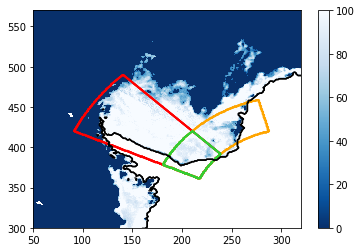

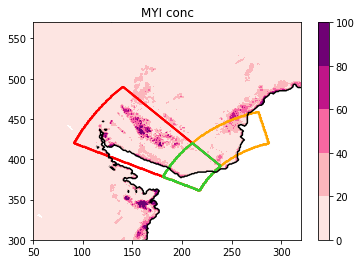

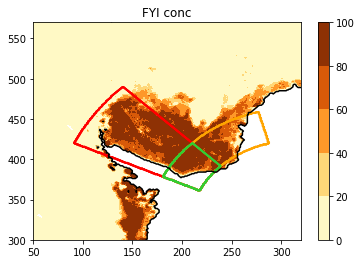

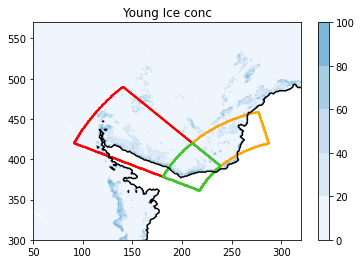

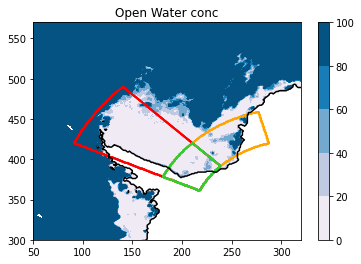

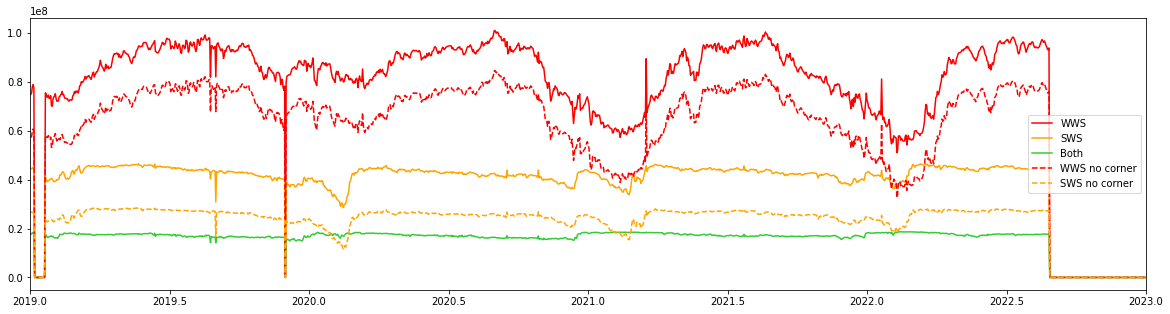

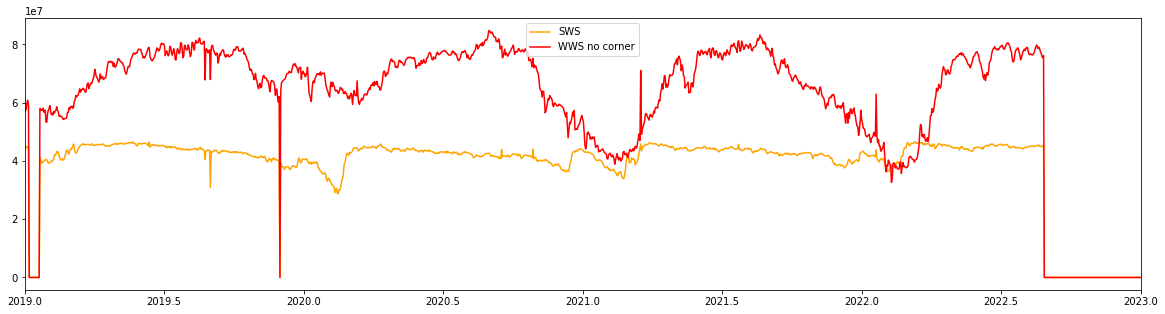

In [60]:
if use_OSISAF:
    
    lat,lon,sic,typ,exist = get_conc_and_type_OSISAF(yr,m,d)
    
    plt.figure()
    plt.pcolormesh(npy.flipud(sic),vmin=0,vmax=1,cmap='Blues_r'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    #plt.contour(npy.flipud(status_flag),[100,101],colors='k')
    plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])

    plt.figure()
    plt.contourf(npy.flipud(typ),4,cmap='Spectral_r'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    if use_OSISAF:
            plt.contour(npy.flipud(status_flag),[100,101],colors='k')
            plt.xlim([100,400])
            plt.ylim([400,700])
    else:
            plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
            plt.xlim([50,320])
            plt.ylim([300,570])


else:
    lat,lon,ice_conc,MYI,FYI,YI,OW,exist = get_conc_and_type(2019,12,30)

    plt.figure()
    plt.pcolormesh(npy.flipud(ice_conc),vmin=0,vmax=100,cmap='Blues_r'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    #plt.contour(npy.flipud(status_flag),[100,101],colors='k')
    plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])
    plt.savefig(figdir+'Ice_conc_map_20191230.png',dpi=100)

    plt.figure()
    plt.contourf(npy.flipud(MYI),4,cmap='RdPu'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    plt.title('MYI conc')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])
    plt.savefig(figdir+'MYI_conc_map_20191230.png',dpi=100)
    
    plt.figure()
    plt.contourf(npy.flipud(FYI),4,cmap='YlOrBr'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    plt.title('FYI conc')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])
    plt.savefig(figdir+'FYI_conc_map_20191230.png',dpi=100)
    
    plt.figure()
    plt.contourf(npy.flipud(YI),4,cmap='Blues',vmin=0,vmax=200); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    plt.title('Young Ice conc')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])
    plt.savefig(figdir+'Young_ice_conc_map_20191230.png',dpi=100)
        
    plt.figure()
    plt.contourf(npy.flipud(OW),4,cmap='PuBu'); plt.colorbar()
    plt.contour(npy.flipud(WWSbox),colors='r')
    plt.contour(npy.flipud(SWSbox),colors='orange')
    plt.contour(npy.flipud(Bothbox),colors='limegreen')
    plt.title('Open Water conc')
    if use_OSISAF:
        plt.contour(npy.flipud(status_flag),[100,101],colors='k')
        plt.xlim([100,400])
        plt.ylim([400,700])
    else:
        plt.contour(npy.flipud(landmask_10),[0.9,1],colors='k')
        plt.xlim([50,320])
        plt.ylim([300,570])
    plt.savefig(figdir+'Open_water_conc_map_20191230.png',dpi=100)
    

plt.figure(figsize=(20,5))
plt.plot(yax[:,0],si_area[:,0],color='r')
plt.plot(yax[:,0],si_area[:,1],color='orange')
plt.plot(yax[:,0],si_area[:,2],color='limegreen')
plt.plot(yax[:,0],si_area[:,3],color='r',linestyle='--')
plt.plot(yax[:,0],si_area[:,4],color='orange',linestyle='--')
plt.legend(['WWS','SWS','Both','WWS no corner','SWS no corner'])
plt.xlim([yrange[0],yrange[-1]+1])
for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,100],'k--')
plt.savefig(figdir+'All_box_SIC_timeseries_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
    
plt.figure(figsize=(20,5))
plt.plot(yax[:,0],si_area[:,1],color='orange')
plt.plot(yax[:,0],si_area[:,3],color='r')
plt.legend(['SWS','WWS no corner'])
plt.savefig(figdir+'SWS_and_WWS_no_corner_box_SIC_timeseries_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,100],'k--')
plt.xlim([yrange[0],yrange[-1]+1])

if use_OSISAF:
    ww = 2*1./(len(yrange)*366)
else:
    ww = 4*1./(len(yrange)*366)


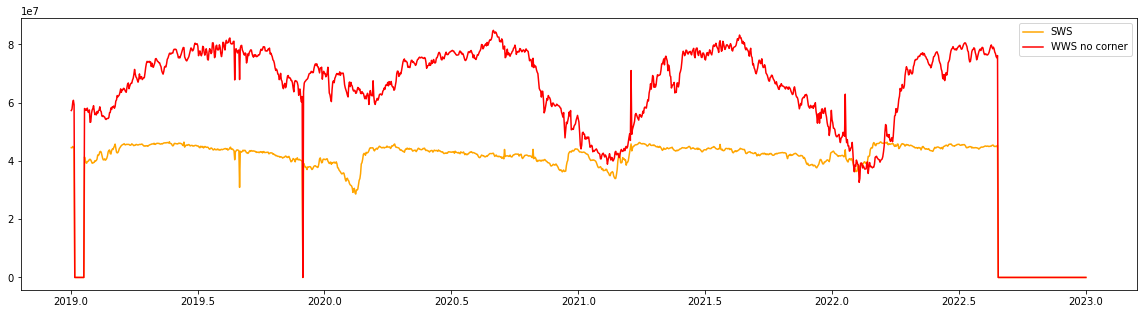

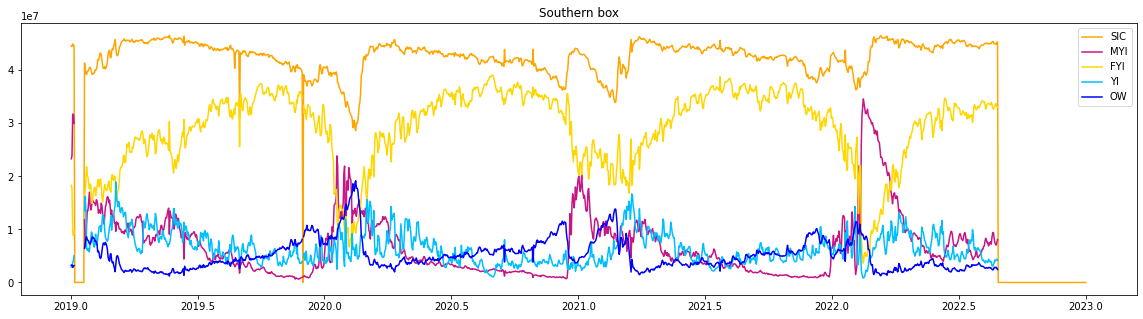

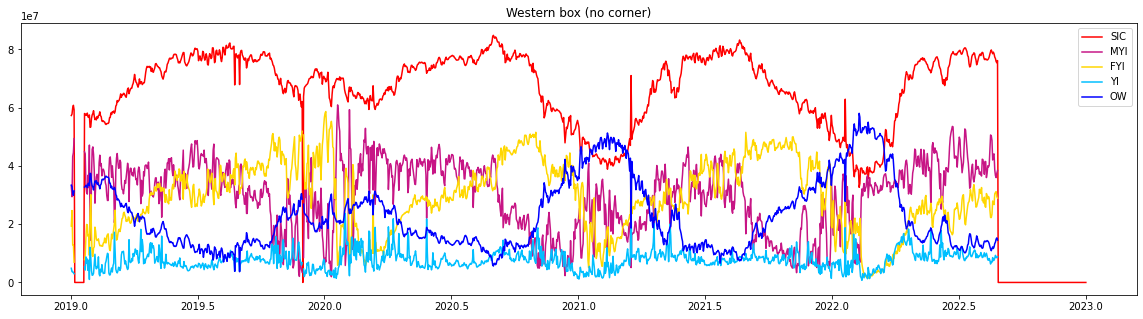

In [61]:
plt.figure(figsize=(20,5))
plt.plot(yax[:,0],si_area[:,1],color='orange')
plt.plot(yax[:,0],si_area[:,3],color='r')
plt.legend(['SWS','WWS no corner'])
plt.savefig(figdir+'SWS_and_WWS_no_corner_box_SIC_timeseries_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

plt.figure(figsize=(20,5))
plt.plot(yax[:,0],si_area[:,1],color='orange')
plt.plot(yax[:,0],myi_area[:,1],color='mediumvioletred')
plt.plot(yax[:,0],fyi_area[:,1],color='gold')
plt.plot(yax[:,0],yi_area[:,1],color='deepskyblue')
plt.plot(yax[:,0],owt_area[:,1],color='blue')
plt.legend(['SIC','MYI','FYI','YI','OW'])
plt.title('Southern box')
plt.savefig(figdir+'SWS_box_all_timeseries_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

plt.figure(figsize=(20,5))
plt.plot(yax[:,0],si_area[:,3],color='red')
plt.plot(yax[:,0],myi_area[:,3],color='mediumvioletred')
plt.plot(yax[:,0],fyi_area[:,3],color='gold')
plt.plot(yax[:,0],yi_area[:,3],color='deepskyblue')
plt.plot(yax[:,0],owt_area[:,3],color='blue')
plt.legend(['SIC','MYI','FYI','YI','OW'])
plt.title('Western box (no corner)')
plt.savefig(figdir+'WWS_no_corner_box_all_timeseries_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

#cmapOSI = mpl.colors.ListedColormap(['blue','deepskyblue','gold','mediumvioletred','grey'])

105.00123497417894
105.00252929160094
105.00334584845186
105.00116422968814
105.00258186062219


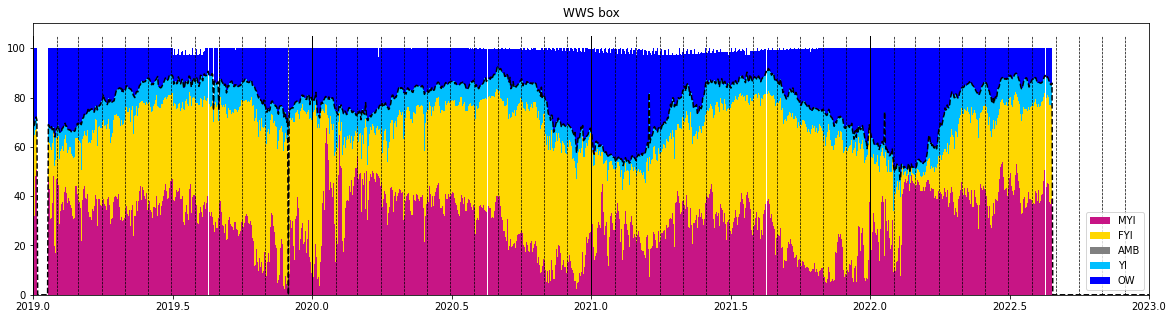

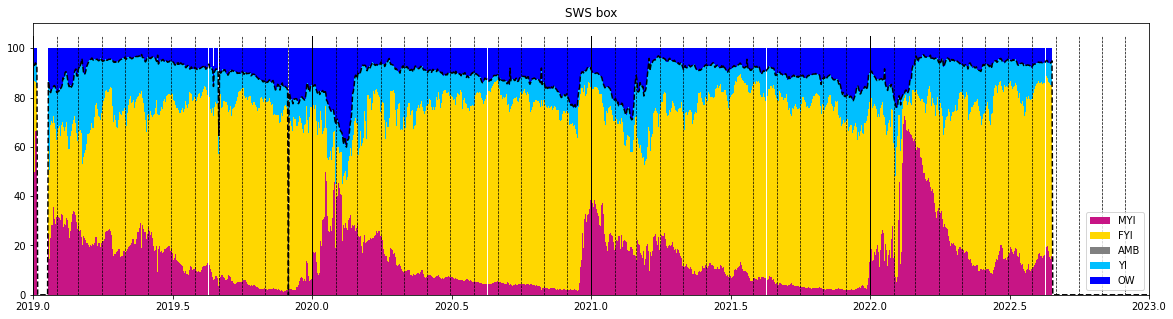

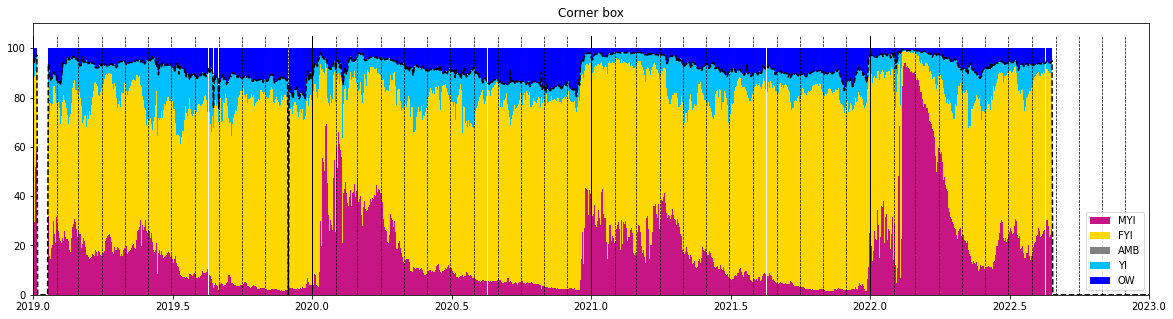

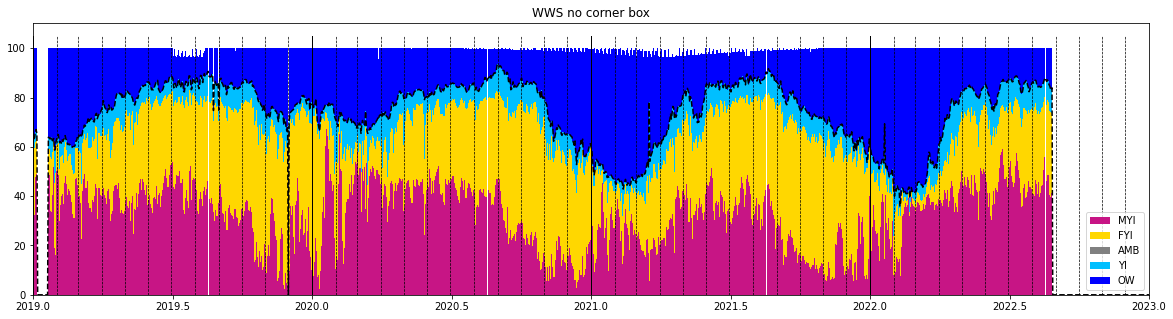

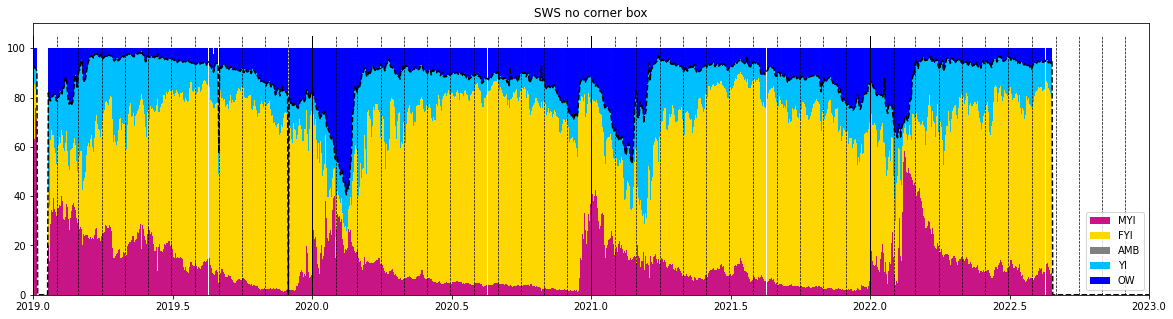

In [62]:
plot_barchart(0,WWS_area,'WWS box')
plt.savefig(figdir+'WWS_box_stacked_bar_proportion_of_100_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(1,SWS_area,'SWS box')
plt.savefig(figdir+'SWS_box_stacked_bar_proportion_of_100_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(2,Both_area,'Corner box')
plt.savefig(figdir+'Corner_box_stacked_bar_proportion_of_100_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(3,WWS_nocorner_area,'WWS no corner box')
plt.savefig(figdir+'WWS_no_corner_box_stacked_bar_proportion_of_100_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(4,SWS_nocorner_area,'SWS no corner box')
plt.savefig(figdir+'SWS_no_corner_box_stacked_bar_proportion_of_100_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

1.0500000000000005
1.0500000000000005
1.0500000000000005
1.0500000000000005
1.0500000000000005


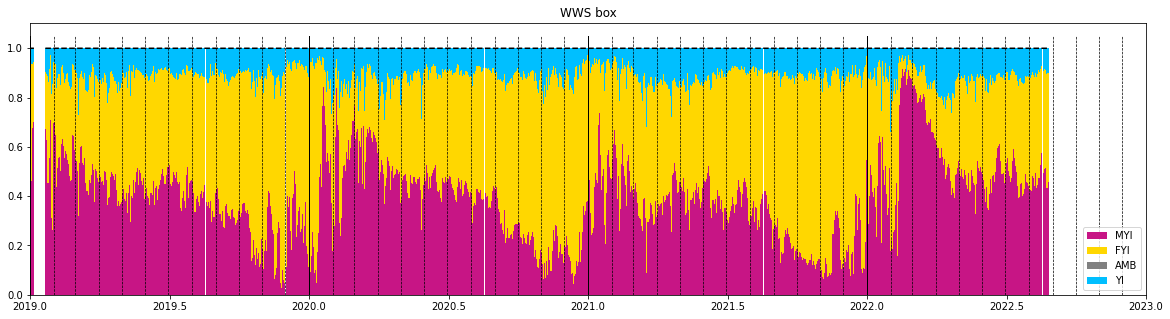

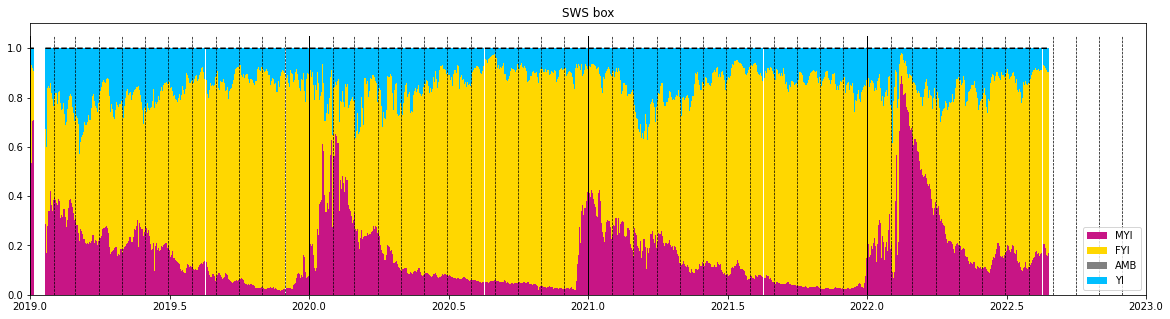

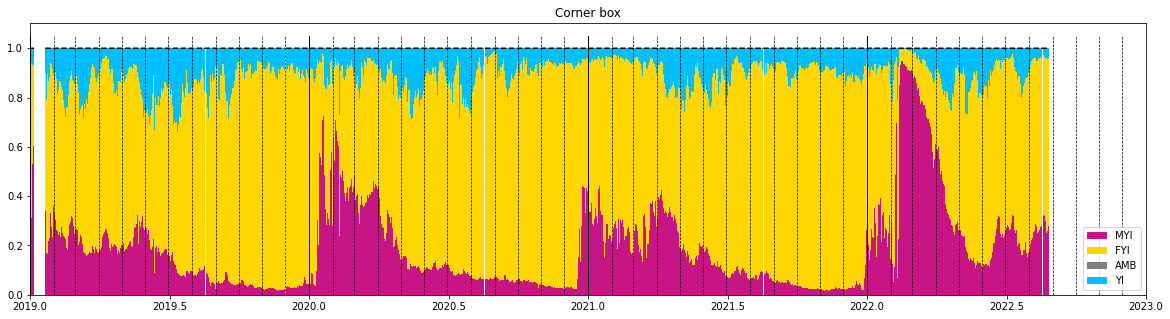

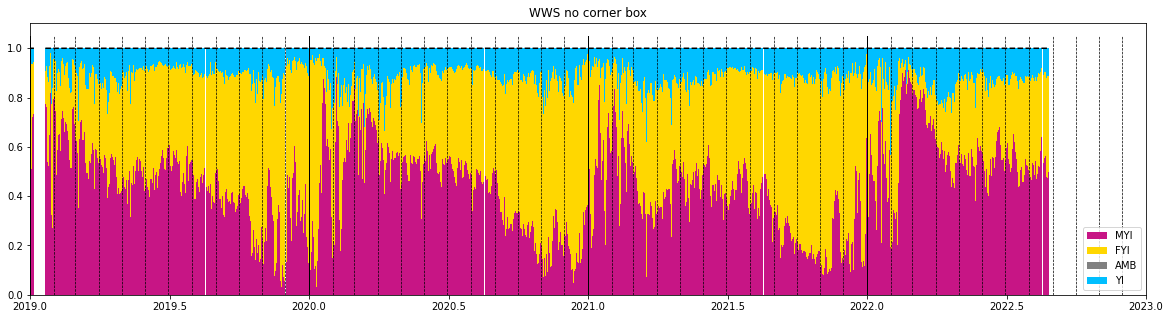

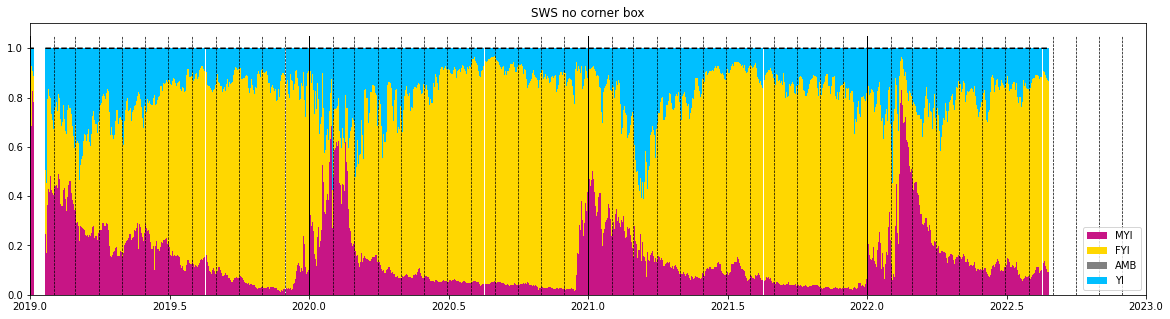

In [63]:
plot_barchart(0,npy.squeeze((myi_area+fyi_area+yi_area)[:,0]),'WWS box',do_OW=0)
plt.savefig(figdir+'WWS_box_stacked_bar_proportion_of_ice_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(1,(myi_area+fyi_area+yi_area)[:,1],'SWS box',do_OW=0)
plt.savefig(figdir+'SWS_box_stacked_bar_proportion_of_ice_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(2,(myi_area+fyi_area+yi_area)[:,2],'Corner box',do_OW=0)
plt.savefig(figdir+'Corner_box_stacked_bar_proportion_of_ice_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(3,(myi_area+fyi_area+yi_area)[:,3],'WWS no corner box',do_OW=0)
plt.savefig(figdir+'WWS_no_corner_box_stacked_bar_proportion_of_ice_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(4,(myi_area+fyi_area+yi_area)[:,4],'SWS no corner box',do_OW=0)
plt.savefig(figdir+'SWS_no_corner_box_stacked_bar_proportion_of_ice_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

114961448.95602912
50168398.20356112
19755841.8365302
95205940.1247217
30412725.224001005


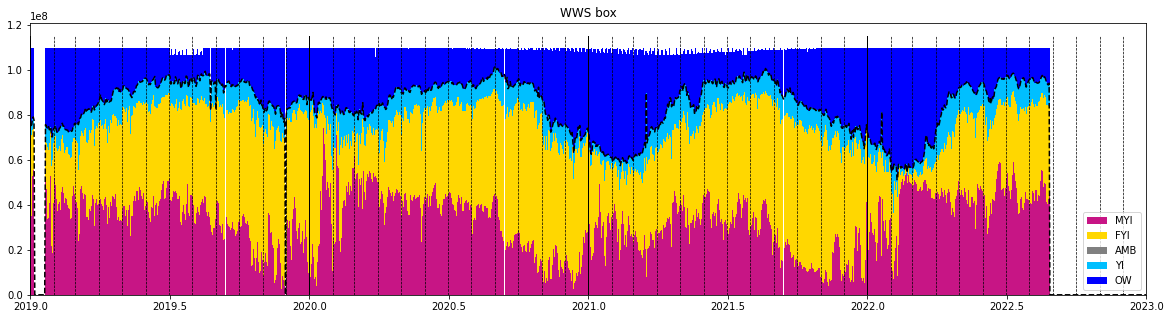

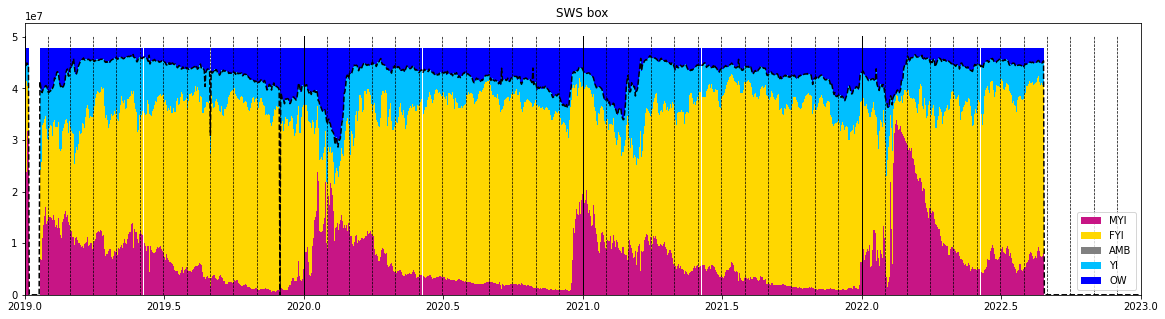

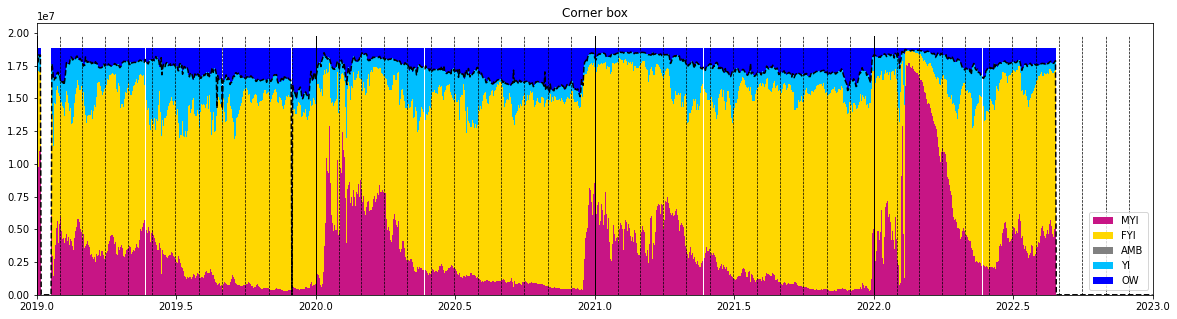

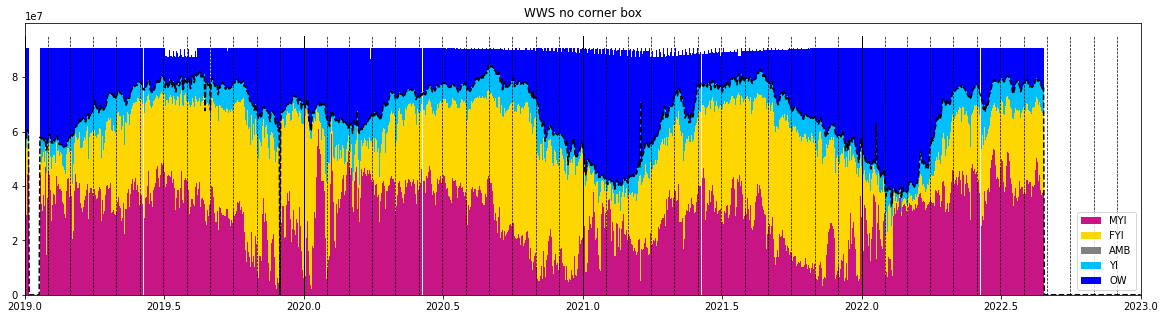

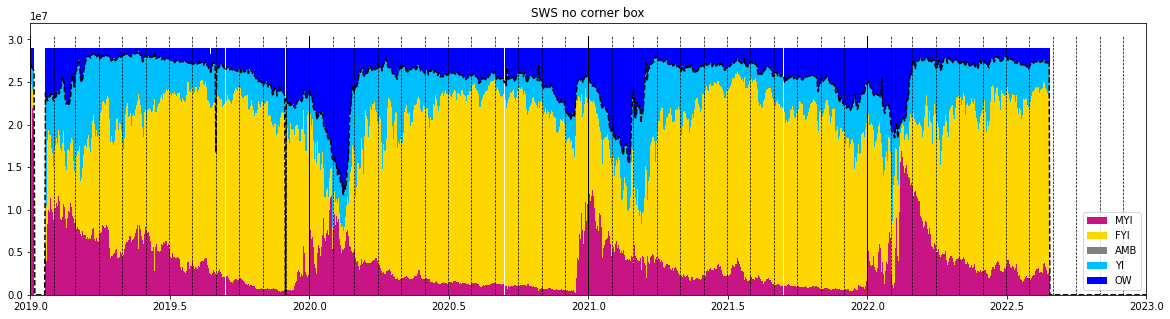

In [64]:
plot_barchart(0,1,'WWS box')
plt.savefig(figdir+'WWS_box_stacked_bar_proportion_of_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(1,1,'SWS box')
plt.savefig(figdir+'SWS_box_stacked_bar_proportion_of_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(2,1,'Corner box')
plt.savefig(figdir+'Corner_box_stacked_bar_proportion_of_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(3,1,'WWS no corner box')
plt.savefig(figdir+'WWS_no_corner_box_stacked_bar_proportion_of_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)
plot_barchart(4,1,'SWS no corner box')
plt.savefig(figdir+'SWS_no_corner_box_stacked_bar_proportion_of_area_'+str(sy)+'-'+str(ey)+'.png',dpi=100)

In [ ]:
for n in range(0,5):
    plt.figure()
    plt.scatter(myi_area[:,n],owt_area[:,n],c=yax[:,0],cmap='jet')

In [ ]:
import sys
sys.exit()

plt.figure(figsize=(20,5))
plt.bar(yax[:,0],myi_area[:,1]/SWS_area,width=ww)
plt.bar(yax[:,0],fyi_area[:,1]/SWS_area,bottom=myi_area[:,1]/SWS_area,width=ww)
plt.bar(yax[:,0],amb_area[:,1]/SWS_area,bottom=myi_area[:,1]/SWS_area+fyi_area[:,1]/SWS_area,width=ww)
plt.bar(yax[:,0],owt_area[:,1]/SWS_area,bottom=myi_area[:,1]/SWS_area+fyi_area[:,1]/SWS_area+amb_area[:,1]/SWS_area,width=ww)
plt.plot(yax[:,0],si_area[:,1],'k--')
for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,1],'k--')
plt.xlim([yrange[0],yrange[-1]+1])
plt.title('SWS box')

plt.figure(figsize=(20,5))
plt.bar(yax[:,0],myi_area[:,2]/Both_area,width=ww)
plt.bar(yax[:,0],fyi_area[:,2]/Both_area,bottom=myi_area[:,2]/Both_area,width=ww)
plt.bar(yax[:,0],amb_area[:,2]/Both_area,bottom=myi_area[:,2]/Both_area+fyi_area[:,2]/Both_area,width=ww)
plt.bar(yax[:,0],owt_area[:,2]/Both_area,bottom=myi_area[:,2]/Both_area+fyi_area[:,2]/Both_area+amb_area[:,2]/Both_area,width=ww)
plt.plot(yax[:,0],si_area[:,2],'k--')
for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,1],'k--')
plt.xlim([yrange[0],yrange[-1]+1])
plt.title('Corner box')

plt.figure(figsize=(20,5))
plt.bar(yax[:,0],myi_area[:,3]/WWS_nocorner_area,width=ww)
plt.bar(yax[:,0],fyi_area[:,3]/WWS_nocorner_area,bottom=myi_area[:,3]/WWS_nocorner_area,width=ww)
plt.bar(yax[:,0],amb_area[:,3]/WWS_nocorner_area,bottom=myi_area[:,3]/WWS_nocorner_area+fyi_area[:,3]/WWS_nocorner_area,width=ww)
plt.bar(yax[:,0],owt_area[:,3]/WWS_nocorner_area,bottom=myi_area[:,3]/WWS_nocorner_area+fyi_area[:,3]/WWS_nocorner_area+amb_area[:,3]/WWS_nocorner_area,width=ww)
plt.plot(yax[:,0],si_area[:,3],'k--')
for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,1],'k--')
plt.xlim([yrange[0],yrange[-1]+1]) 
plt.title('WWS no corner box')

plt.figure(figsize=(20,5))
plt.bar(yax[:,0],myi_area[:,4]/SWS_nocorner_area,width=ww)
plt.bar(yax[:,0],fyi_area[:,4]/SWS_nocorner_area,bottom=myi_area[:,4]/SWS_nocorner_area,width=ww)
plt.bar(yax[:,0],amb_area[:,4]/SWS_nocorner_area,bottom=myi_area[:,4]/SWS_nocorner_area+fyi_area[:,4]/SWS_nocorner_area,width=ww)
plt.bar(yax[:,0],owt_area[:,4]/SWS_nocorner_area,bottom=myi_area[:,4]/SWS_nocorner_area+fyi_area[:,4]/SWS_nocorner_area+amb_area[:,4]/SWS_nocorner_area,width=ww)
plt.plot(yax[:,0],si_area[:,4],'k--')
for nn in range(0,len(m_points)):
    plt.plot([m_points[nn],m_points[nn]],[0,1],'k--')
plt.xlim([yrange[0],yrange[-1]+1])
plt.title('SWS no corner box')